In [6]:
# Mount Google Drive if you are storing your dataset there
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt

# Define the dataset paths
image_folder = '/content/drive/MyDrive/Dataset/Fetal Abdominal Structures Segmentation Dataset Using Ultrasonic Images/IMAGES'
mask_folder = '/content/drive/MyDrive/Dataset/Fetal Abdominal Structures Segmentation Dataset Using Ultrasonic Images/ARRAY_FORMAT'


In [ ]:
# Get sorted lists of file paths for consistency
image_files = sorted(glob(os.path.join(image_folder, '*.png')))
mask_files = sorted(glob(os.path.join(mask_folder, '*.npy')))

# Verify pairing by checking the first pair
print(f"Example pair - Image: {image_files[0]}, Mask: {mask_files[0]}")


Example pair - Image: /content/drive/MyDrive/Dataset/Fetal Abdominal Structures Segmentation Dataset Using Ultrasonic Images/IMAGES/P0100_IMG1.png, Mask: /content/drive/MyDrive/Dataset/Fetal Abdominal Structures Segmentation Dataset Using Ultrasonic Images/ARRAY_FORMAT/P0100_IMG1.npy


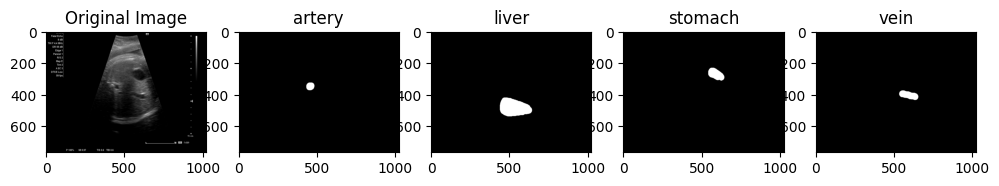

In [ ]:
def visualize_sample(image_path, mask_path):
    # Load the image and mask data
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask_data = np.load(mask_path, allow_pickle=True).item()

    # Plot the original image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, len(mask_data['structures']) + 1, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')

    # Plot each structure mask
    for i, (name, mask) in enumerate(mask_data['structures'].items(), start=2):
        plt.subplot(1, len(mask_data['structures']) + 1, i)
        plt.imshow(mask, cmap='gray')
        plt.title(name)

    plt.show()

# Test visualization on one sample
visualize_sample(image_files[0], mask_files[0])


In [7]:
# Collect pairs for segmentation training
dataset = []
for img_path, mask_path in zip(image_files, mask_files):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask_data = np.load(mask_path, allow_pickle=True).item()
    dataset.append((image, mask_data['structures']))  # Store the image and its structure masks


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def unet_model(input_shape):
    inputs = Input(input_shape)

    # Down-sampling
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Down-sample more layers if needed...

    # Up-sampling
    u1 = UpSampling2D((2, 2))(p1)
    u1 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    u1 = concatenate([u1, c1])

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u1)  # Adjust the number of output channels based on structure masks

    return Model(inputs=[inputs], outputs=[outputs])

# Compile the model
input_shape = (256, 256, 1)  # Adjust to your dataset’s dimensions
model = unet_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 256, 256, 64)   │              0 │ max_pooling2d[0][0]    │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 256, 256, 128)  │              0 │ conv2d_2[0][0],        │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 1)    │            129 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 74,625 (291.50 KB)

 Trainable params: 74,625 (291.50 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, dataset, batch_size=8, dim=(256, 256), n_channels=1, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.dataset) // self.batch_size

    def __getitem__(self, index):
        batch_data = self.dataset[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_data)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.dataset)

    def __data_generation(self, batch_data):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_channels))

        for i, (image, masks) in enumerate(batch_data):
            image_resized = cv2.resize(image, self.dim)
            X[i,] = np.expand_dims(image_resized, axis=-1) / 255.0  # Normalize image

            # Combine masks for segmentation
            combined_mask = np.zeros(self.dim)
            for mask in masks.values():
                mask_resized = cv2.resize(mask, self.dim)
                combined_mask = np.maximum(combined_mask, mask_resized)

            y[i,] = np.expand_dims(combined_mask, axis=-1) / 255.0  # Normalize mask

        return X, y

# Initialize generator
train_gen = DataGenerator(dataset, batch_size=8, dim=(256, 256))


In [10]:
# Train the model
epochs = 10
model.fit(train_gen, epochs=epochs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


198/198 ━━━━━━━━━━━━━━━━━━━━ 22s 73ms/step - accuracy: 0.9474 - loss: 0.1348
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - accuracy: 0.9496 - loss: 0.0018
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - accuracy: 0.9503 - loss: 0.0017
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9497 - loss: 0.0017
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9494 - loss: 0.0017
Epoch 6/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.9496 - loss: 0.0017
Epoch 7/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.9498 - loss: 0.0017
Epoch 8/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.9498 - loss: 0.0017
Epoch 9/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9499 - loss: 0.0016
Epoch 10/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.9495 - loss: 0.0017


In [11]:
# Save model after training (optional)
model.save('/content/unet_fetal_detection_model.h5')

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path, dim=(256, 256)):
    # Load and resize the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_resized = cv2.resize(image, dim)
    # Normalize and add channel dimension
    image_resized = np.expand_dims(image_resized, axis=-1) / 255.0
    # Add batch dimension
    image_resized = np.expand_dims(image_resized, axis=0)
    return image_resized

# Example usage
image_path = '/content/Patient01096_Plane2_2_of_2.png'
input_image = preprocess_image(image_path)


In [13]:
# Perform prediction
predicted_mask = model.predict(input_image)

# Remove batch and channel dimensions for visualization
predicted_mask = predicted_mask[0, :, :, 0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


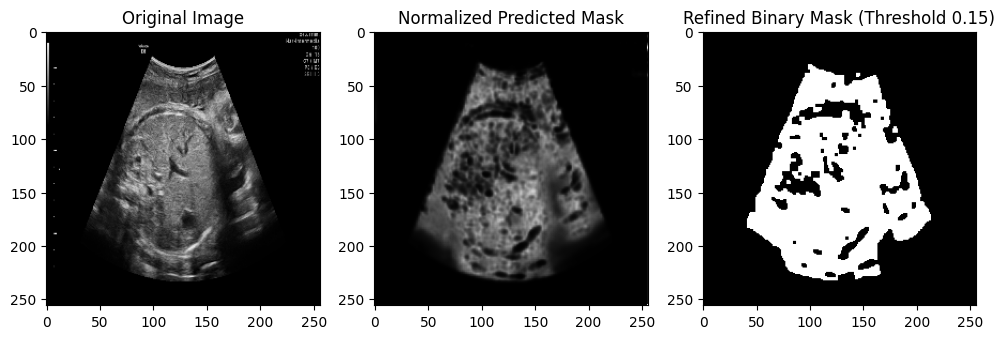

In [18]:
import cv2

# Experiment with a slightly higher threshold
adjusted_threshold = 0.15
binary_mask = (normalized_mask > adjusted_threshold).astype(np.uint8)

# Apply morphological operations to clean up the mask
# Use a kernel for morphological operations
kernel = np.ones((3, 3), np.uint8)

# Apply opening (erosion followed by dilation) to remove small artifacts
binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)

# Apply closing (dilation followed by erosion) to close small holes
binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

# Display the refined mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(original_image_resized, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(normalized_mask, cmap='gray')
plt.title('Normalized Predicted Mask')

plt.subplot(1, 3, 3)
plt.imshow(binary_mask, cmap='gray')
plt.title(f'Refined Binary Mask (Threshold {adjusted_threshold})')

plt.show()


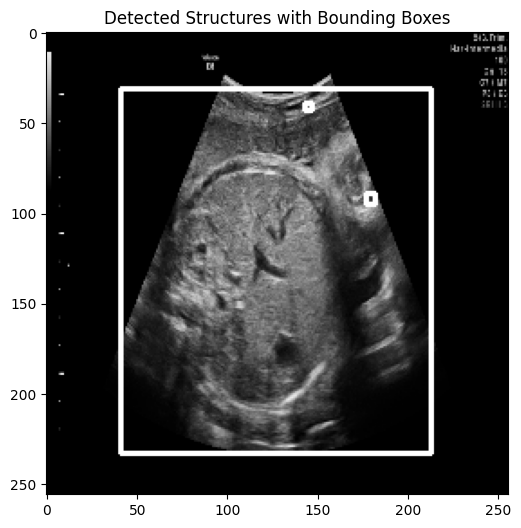

In [19]:
def get_bounding_boxes(binary_mask):
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
    return bounding_boxes

# Extract bounding boxes from the refined binary mask
bounding_boxes = get_bounding_boxes(binary_mask)

# Draw bounding boxes on the original image
image_with_boxes = original_image_resized.copy()
for (x, y, w, h) in bounding_boxes:
    cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Display the image with bounding boxes
plt.figure(figsize=(6, 6))
plt.imshow(image_with_boxes, cmap='gray')
plt.title('Detected Structures with Bounding Boxes')
plt.show()


In [20]:
# Check the range of the predicted mask values
print("Predicted Mask - min value:", predicted_mask.min())
print("Predicted Mask - max value:", predicted_mask.max())

Predicted Mask - min value: 1.5215222e-09
Predicted Mask - max value: 0.0016506864
